In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from collections import OrderedDict

from scipy.stats import mannwhitneyu, chisquare, ttest_ind
from patsy import dmatrices
import statsmodels.api as sm 

# 1. Data

## 1.1) Data Cleaning

In [2]:
data = pd.read_excel('../data/20090101_20180228_sarcoma_pathol만388_의뢰_pathol.xlsx')
data.head()

,NoPat,Unnamed: 1,Unnamed: 2,FNCLCC grade,Sex,Age,생년월일,검사시행일자,처방코드NM,Unnamed: 9,...,original_glszm_HighGrayLevelZoneEmphasis_Ceb,original_glszm_SmallAreaEmphasis_Ceb,original_glszm_LowGrayLevelZoneEmphasis_Ceb,original_glszm_ZoneEntropy_Ceb,original_glszm_SmallAreaLowGrayLevelEmphasis_Ceb,original_ngtdm_Coarseness_Ceb,original_ngtdm_Complexity_Ceb,original_ngtdm_Strength_Ceb,original_ngtdm_Contrast_Ceb,original_ngtdm_Busyness_Ceb
0,1.0,5179800,Low grade fibromyxoid sarcoma,1,F,56.0,1956.0,2012.0,MRI Rt Thigh(contrast),NaN,...,429.327209,0.567483,0.004751,7.240740,0.002282,0.000214,2840.769632,0.195718,0.273955,11.514650
1,2.0,5892175,Acral myxoinflammatory fibroblastic sarcoma,1,F,73.0,1941.0,2014.0,MRI Lt Lower leg( contrast ),NaN,...,18.393617,0.326618,0.134259,6.049463,0.048302,0.000072,19.874421,0.003774,0.008955,302.652735
2,3.0,7367069,Myxoid liposarcoma (no round cell),2,F,55.0,1958.0,2013.0,MRI Lt Thigh(contrast),NaN,...,22.548387,0.461276,0.114277,5.519628,0.055614,0.001171,15.640958,0.034334,0.031259,22.287664
3,4.0,7476129,Pleomorphic liposarcoma,3,M,77.0,1935.0,2012.0,MRI Pelvic bone ( contrast),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,7730046,High grade pleomorphic sarcoma,3,M,44.0,1971.0,2015.0,MRI Lt Thigh(contrast),NaN,...,536.648303,0.547752,0.002463,7.116584,0.001357,0.000057,944.018910,0.043005,0.048227,14.349307


In [3]:
data.rename(
    {'Unnamed: 1':'ID', 'Unnamed: 2':'진단명'}, 
    axis='columns', 
    inplace=True)
drop_cols = ['NoPat', 'ID', '진단명', 'Unnamed: 9', 'Unnamed: 10', 395]
data.drop(drop_cols, 1, inplace=True)
data.head()

,FNCLCC grade,Sex,Age,생년월일,검사시행일자,처방코드NM,Region,Region_simplified,general_info_VolumeNum_T1,general_info_VoxelNum_T1,...,original_glszm_HighGrayLevelZoneEmphasis_Ceb,original_glszm_SmallAreaEmphasis_Ceb,original_glszm_LowGrayLevelZoneEmphasis_Ceb,original_glszm_ZoneEntropy_Ceb,original_glszm_SmallAreaLowGrayLevelEmphasis_Ceb,original_ngtdm_Coarseness_Ceb,original_ngtdm_Complexity_Ceb,original_ngtdm_Strength_Ceb,original_ngtdm_Contrast_Ceb,original_ngtdm_Busyness_Ceb
0,1,F,56.0,1956.0,2012.0,MRI Rt Thigh(contrast),Thigh,LEG,1.0,32112.0,...,429.327209,0.567483,0.004751,7.240740,0.002282,0.000214,2840.769632,0.195718,0.273955,11.514650
1,1,F,73.0,1941.0,2014.0,MRI Lt Lower leg( contrast ),Lower leg,LEG,1.0,87743.0,...,18.393617,0.326618,0.134259,6.049463,0.048302,0.000072,19.874421,0.003774,0.008955,302.652735
2,2,F,55.0,1958.0,2013.0,MRI Lt Thigh(contrast),Thigh,LEG,1.0,10208.0,...,22.548387,0.461276,0.114277,5.519628,0.055614,0.001171,15.640958,0.034334,0.031259,22.287664
3,3,M,77.0,1935.0,2012.0,MRI Pelvic bone ( contrast),Pelvis,LEG,1.0,32633.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,M,44.0,1971.0,2015.0,MRI Lt Thigh(contrast),Thigh,LEG,1.0,278182.0,...,536.648303,0.547752,0.002463,7.116584,0.001357,0.000057,944.018910,0.043005,0.048227,14.349307


## 1.2) NA 제거

In [4]:
print(data.shape, data.dropna().shape)
data.dropna(inplace=True)

(399, 327) (307, 327)


## 1.3) FNCLCC grade -> Binary Class
### 1.3.1) Binary Class
- Grade 0,1,2,3 을 제외하고 모두 제거

In [5]:
data['FNCLCC grade'].value_counts()

3           88
1           79
0           68
2           67
No grade     3
???          1
1?           1
Name: FNCLCC grade, dtype: int64

In [6]:
print('before data shape:', data.shape)
binary_idx = data['FNCLCC grade'].apply(lambda x: True if x in [0,1,2,3] else False)
binary_data = data.drop(data[~binary_idx].index, 0)
print('after data shape:', binary_data.shape)

before data shape: (307, 327)
after data shape: (302, 327)


In [7]:
binary_data.loc[:,'label'] = binary_data['FNCLCC grade'].apply(lambda x: 0 if x < 1 else 1)
binary_data.head()

,FNCLCC grade,Sex,Age,생년월일,검사시행일자,처방코드NM,Region,Region_simplified,general_info_VolumeNum_T1,general_info_VoxelNum_T1,...,original_glszm_SmallAreaEmphasis_Ceb,original_glszm_LowGrayLevelZoneEmphasis_Ceb,original_glszm_ZoneEntropy_Ceb,original_glszm_SmallAreaLowGrayLevelEmphasis_Ceb,original_ngtdm_Coarseness_Ceb,original_ngtdm_Complexity_Ceb,original_ngtdm_Strength_Ceb,original_ngtdm_Contrast_Ceb,original_ngtdm_Busyness_Ceb,label
0,1,F,56.0,1956.0,2012.0,MRI Rt Thigh(contrast),Thigh,LEG,1.0,32112.0,...,0.567483,0.004751,7.240740,0.002282,0.000214,2840.769632,0.195718,0.273955,11.514650,1
1,1,F,73.0,1941.0,2014.0,MRI Lt Lower leg( contrast ),Lower leg,LEG,1.0,87743.0,...,0.326618,0.134259,6.049463,0.048302,0.000072,19.874421,0.003774,0.008955,302.652735,1
2,2,F,55.0,1958.0,2013.0,MRI Lt Thigh(contrast),Thigh,LEG,1.0,10208.0,...,0.461276,0.114277,5.519628,0.055614,0.001171,15.640958,0.034334,0.031259,22.287664,1
4,3,M,44.0,1971.0,2015.0,MRI Lt Thigh(contrast),Thigh,LEG,1.0,278182.0,...,0.547752,0.002463,7.116584,0.001357,0.000057,944.018910,0.043005,0.048227,14.349307,1
5,1,M,56.0,1959.0,2015.0,MRI Both Hip ( contrast),Pelvis,LEG,1.0,110452.0,...,0.486944,0.011030,7.182278,0.005102,0.000156,326.115753,0.069735,0.028074,19.066835,1


### 1.3.2) Binary Class Train/Validation

In [8]:
original_cols = [col for col in data.columns if 'original' in col]
original_cols.append('label')
bi_train_idx = binary_data['검사시행일자'].astype(int)<=2016
bi_train = binary_data.loc[bi_train_idx, original_cols]
bi_valid = binary_data.loc[~bi_train_idx, original_cols]
print(bi_train.shape, bi_valid.shape)

(243, 316) (59, 316)


### 1.3.3) Label 비교

In [9]:
print('total data')
print(pd.DataFrame({
    'Count':binary_data.label.value_counts(),
    'Ratio':round(binary_data.label.value_counts()/len(binary_data),2)}))

print('train data')
print(pd.DataFrame({
    'Count':bi_train.label.value_counts(),
    'Ratio':round(bi_train.label.value_counts()/len(bi_train),2)}))

print('valid data')
print(pd.DataFrame({
    'Count':bi_valid.label.value_counts(),
    'Ratio':round(bi_valid.label.value_counts()/len(bi_valid),2)}))

print('train data 검정')
print(chisquare(
    bi_train.label.value_counts().values, 
    (len(bi_train)*(binary_data.label.value_counts().values/len(binary_data)).round(2)).round())
)
print('valid data 검정')
print(chisquare(
    bi_valid.label.value_counts().values, 
    (len(bi_valid)*(binary_data.label.value_counts().values/len(binary_data)).round(2)).round()))

total data
   Count  Ratio
1    234   0.77
0     68   0.23
train data
   Count  Ratio
1    191   0.79
0     52   0.21
valid data
   Count  Ratio
1     43   0.73
0     16   0.27
train data 검정
Power_divergenceResult(statistic=0.3712757830404889, pvalue=0.542309677070143)
valid data 검정
Power_divergenceResult(statistic=0.3746031746031746, pvalue=0.5405057730881039)


### 1.3.4) 성별 비교

In [10]:
print('total data')
print(pd.DataFrame({
    'Count':binary_data.Sex.value_counts(),
    'Ratio':round(binary_data.Sex.value_counts()/len(binary_data),2)}))

print('train data')
print(pd.DataFrame({
    'Count':binary_data[bi_train_idx].Sex.value_counts(),
    'Ratio':round(binary_data[bi_train_idx].Sex.value_counts()/len(bi_train),2)}))

print('valid data')
print(pd.DataFrame({
    'Count':binary_data[~bi_train_idx].Sex.value_counts(),
    'Ratio':round(binary_data[~bi_train_idx].Sex.value_counts()/len(bi_valid),2)}))

print('train data 검정')
print(chisquare(
    binary_data[bi_train_idx].Sex.value_counts().values, 
    (len(bi_train)*(binary_data.Sex.value_counts().values/len(binary_data)).round(2)).round())
)
print('valid data 검정')
print(chisquare(
    binary_data[~bi_train_idx].Sex.value_counts().values, 
    (len(bi_valid)*(binary_data.Sex.value_counts().values/len(binary_data)).round(2)).round()))

total data
   Count  Ratio
M    169   0.56
F    133   0.44
train data
   Count  Ratio
M    143   0.59
F    100   0.41
valid data
   Count  Ratio
F     33   0.56
M     26   0.44
train data 검정
Power_divergenceResult(statistic=0.8182380428807037, pvalue=0.36569582479472973)
valid data 검정
Power_divergenceResult(statistic=0.0, pvalue=1.0)


### 1.3.5) 나이 비교

In [11]:
print('total data')
print(binary_data.Age.mean(),round(binary_data.Age.std(),2))

print('train bata')
print(round(binary_data[bi_train_idx].Age.mean(), 2), round(binary_data[bi_train_idx].Age.std(), 2))

print('valid data')
print(round(binary_data[~bi_train_idx].Age.mean(), 2), round(binary_data[~bi_train_idx].Age.std(), 2))

print('train data 검정')
print(ttest_ind(binary_data[bi_train_idx].Age, binary_data.Age))

print('valid data 검정')
print(ttest_ind(binary_data[~bi_train_idx].Age, binary_data.Age))

total data
50.5 19.06
train bata
49.6 19.79
valid data
54.22 15.31
train data 검정
Ttest_indResult(statistic=-0.5406776932711642, pvalue=0.5889514661525148)
valid data 검정
Ttest_indResult(statistic=1.4123488824490873, pvalue=0.15871352008170253)


# 1.4) 데이터 준비

In [12]:
X_train = bi_train.drop('label',1)
y_train = bi_train.label.values
X_valid = bi_valid.drop('label',1)
y_valid = bi_valid.label.values

# 2. Lasso
## 2.1 skelarn LassoCV

### 2.1.2) Baseline

In [13]:
lasso_auc_scores = []
cv_idx = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_valid) in enumerate(cv_idx.split(bi_train)):
    cv_X_train = X_train.iloc[idx_train]
    cv_y_train = y_train[idx_train]
    cv_X_valid = X_train.iloc[idx_valid]
    cv_y_valid = y_train[idx_valid]
    
    # 1. lasso
    lasso_model = LassoCV(cv=5,  max_iter=1e6, eps=1e-2, random_state=0)
    lasso_model.fit(cv_X_train, cv_y_train)
    lasso_valid_auc = metrics.roc_auc_score(cv_y_valid,
                                            lasso_model.predict(cv_X_valid))
    lasso_auc_scores.append(lasso_valid_auc)    
    
    print('{0}th fold result {1}'.format(i, lasso_valid_auc))
print('mean auc score is {0}'.format(np.mean(lasso_auc_scores)))

0th fold result 0.8938775510204082
1th fold result 0.7896341463414633
2th fold result 0.7568627450980392
3th fold result 0.778125
4th fold result 0.6968641114982578
mean auc score is 0.7830727107916338


In [14]:
lasso_model = LassoCV(cv=5, max_iter=1e6, eps=1e-2, random_state=0)
lasso_model.fit(X_train, y_train)
lasso_auc = metrics.roc_auc_score(
    y_valid,
    lasso_model.predict(X_valid))
lasso_auc

0.7398255813953489

### 2.1.2) Standard Scale

In [15]:
scaler = StandardScaler().fit(X_train)
scale_X_train = scaler.transform(X_train)
scale_X_valid = scaler.transform(X_valid)

In [16]:
lasso_auc_scores = []
cv_idx = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_valid) in enumerate(cv_idx.split(bi_train)):
    cv_X_train = scale_X_train[idx_train]
    cv_y_train = y_train[idx_train]
    cv_X_valid = scale_X_train[idx_valid]
    cv_y_valid = y_train[idx_valid]
    
    # 1. lasso
    lasso_model = LassoCV(cv=5,  max_iter=1e6, eps=1e-2, random_state=0)
    lasso_model.fit(cv_X_train, cv_y_train)
    lasso_valid_auc = metrics.roc_auc_score(cv_y_valid,
                                            lasso_model.predict(cv_X_valid))
    lasso_auc_scores.append(lasso_valid_auc)    
    
    print('{0}th fold result {1}'.format(i, lasso_valid_auc))
print('mean auc score is {0}'.format(np.mean(lasso_auc_scores)))

0th fold result 0.9816326530612245
1th fold result 0.8048780487804879
2th fold result 0.7098039215686274
3th fold result 0.871875
4th fold result 0.9477351916376306
mean auc score is 0.863184963009594


In [17]:
lasso_model = LassoCV(cv=5, max_iter=1e6, eps=1e-2, random_state=0)
lasso_model.fit(scale_X_train, y_train)
lasso_auc = metrics.roc_auc_score(
    y_valid,
    lasso_model.predict(scale_X_valid))
lasso_auc

0.8270348837209303

### 2.1.3) Standard Scale Coef

In [18]:
lasso_df = pd.DataFrame({
    'Feature': bi_train.columns.values[:-1][lasso_model.coef_!=0],
    'Coef':lasso_model.coef_[lasso_model.coef_!=0]
})
lasso_df.loc[:,'abs'] = abs(lasso_df.Coef)
lasso_df.sort_values(by='abs', ascending=False, inplace=True)
lasso_df.drop('abs',1.,inplace=True)
lasso_df= pd.concat([
    pd.DataFrame({
        'Feature': 'Intercept',
        'Coef': [lasso_model.intercept_]}),
    lasso_df],
    axis=0,
    sort=False)
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Feature,Coef
0,Intercept,0.786008
1,original_firstorder_Minimum_T1,-0.086002
2,original_glrlm_RunEntropy_Ceb,0.084751
3,original_shape_LeastAxis_T2b,0.074361
4,original_gldm_SmallDependenceLowGrayLevelEmpha...,0.071820
5,original_firstorder_Skewness_T1,0.053778
6,original_ngtdm_Coarseness_Ceb,0.051041
7,original_glcm_MaximumProbability_T1,0.048424
8,original_glszm_LargeAreaHighGrayLevelEmphasis_T1,-0.047734
9,original_glrlm_LongRunLowGrayLevelEmphasis_T1,-0.041906


## 2.2 Rad Score

In [19]:
rad_one = lasso_model.predict(scale_X_valid)[y_valid==1]
rad_zero = lasso_model.predict(scale_X_valid)[y_valid==0]

print(np.percentile(rad_zero,[0,25,50,75,100]).round(2),
     rad_zero.mean().round(2))
print(np.percentile(rad_one,[0,25,50,75,100]).round(2),
      rad_one.mean().round(2))

[-0.54  0.35  0.5   0.67  1.38] 0.5
[0.37 0.69 0.86 0.98 1.28] 0.85


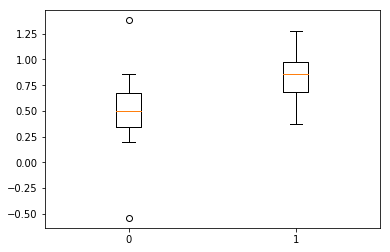

In [20]:
plt.boxplot([rad_zero, 
             rad_one],
            labels=['0','1'])
plt.show()

In [21]:
mannwhitneyu(rad_zero,rad_one)

MannwhitneyuResult(statistic=119.0, pvalue=6.467491466232758e-05)

In [22]:
uni_data = pd.DataFrame({
    'label': y_valid,
    'rad_score': lasso_model.predict(scale_X_valid)
})
y, X = dmatrices( 'label ~ rad_score', data=uni_data, return_type='dataframe')
mod = sm.Logit(y, X)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.440308
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   59
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                  0.2466
Time:                        14:17:00   Log-Likelihood:                -25.978
converged:                       True   LL-Null:                       -34.482
                                        LLR p-value:                 3.724e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6940      1.146     -2.352      0.019      -4.939      -0.449
rad_score      5.2688      1.

In [23]:
params = res.params
conf = res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))
print(conf)

               2.5%        97.5%          OR
Intercept  0.007160     0.638433    0.067613
rad_score  7.768212  4853.877253  194.180197
               2.5%     97.5%        OR
Intercept -4.939183 -0.448738 -2.693961
rad_score  2.050040  8.487533  5.268787


## 2.2 R glmnet

In [39]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as n2r
n2r.activate()

r_glmnet = importr('glmnet')
r_base = importr('base')
r_stats = importr('stats')

### 2.2.1) R with raw

In [30]:
nr,nc = X_train.shape
X_train_r = ro.r.matrix(X_train.values, nrow=nr, ncol=nc)
ro.r.assign("X_train_r", X_train_r)

nr,nc = X_valid.shape
X_valid_r = ro.r.matrix(X_valid.values, nrow=nr, ncol=nc)
ro.r.assign("X_valid_r", X_valid_r)

y_train_r = ro.IntVector(y_train)
ro.r.assign("y_train_r", y_train_r)

1,1,1,...,0,1,1


In [33]:
lasso_model_r = r_glmnet.cv_glmnet(
    x=ro.r['X_train_r'], 
    y=ro.r['y_train_r'], 
    family='binomial')

lasso_pred_r = ro.r.predict(lasso_model_r,
             newx=ro.r['X_valid_r'],
             s=lasso_model_r.rx2("lambda.min"), 
             type="response",
             type_measure="deviance")

lasso_auc = metrics.roc_auc_score(
    y_valid,
    np.array(lasso_pred_r))

lasso_auc

0.8197674418604651

### 2.2.2) R with standard scale

In [34]:
nr,nc = scale_X_train.shape
scale_X_train_r = ro.r.matrix(scale_X_train, nrow=nr, ncol=nc)
ro.r.assign("scale_X_train_r", scale_X_train_r)

nr,nc = scale_X_valid.shape
scale_X_valid_r = ro.r.matrix(scale_X_valid, nrow=nr, ncol=nc)
ro.r.assign("scale_X_valid_r", scale_X_valid_r)

2.200805,-1.219387,1.507711,...,3.842007,0.966975,-0.424694


In [36]:
lasso_model_r = r_glmnet.cv_glmnet(
    x=ro.r['scale_X_train_r'], 
    y=ro.r['y_train_r'], 
    family='binomial')

lasso_pred_r = ro.r.predict(lasso_model_r,
             newx=ro.r['scale_X_valid_r'],
             s=lasso_model_r.rx2("lambda.min"), 
             type="response",
             type_measure="deviance")

lasso_auc = metrics.roc_auc_score(
    y_valid,
    np.array(lasso_pred_r))
lasso_auc

0.8386627906976745

### 2.2.3) glmnet Coef

In [58]:
r_coef = np.array(
    r_base.as_matrix(
        r_stats.coef(lasso_model_r, s=lasso_model_r.rx2("lambda.min"))
    )).flatten()
col_names = ['Intercept']
col_names.extend(X_train.columns.values)
lasso_df = pd.DataFrame({
    'Feature': np.array(col_names)[r_coef!=0],
    'Coef':r_coef[r_coef!=0]
})
lasso_df

,Feature,Coef
0,Intercept,1.835538
1,original_gldm_LargeDependenceLowGrayLevelEmpha...,-0.051068
2,original_gldm_DependenceVariance_T1,0.140504
3,original_gldm_SmallDependenceLowGrayLevelEmpha...,0.349673
4,original_firstorder_Skewness_T1,0.506079
5,original_firstorder_Minimum_T1,-0.525973
6,original_firstorder_Kurtosis_T1,0.286531
7,original_glrlm_LongRunLowGrayLevelEmphasis_T1,-0.097720
8,original_glszm_LargeAreaHighGrayLevelEmphasis_T1,-0.281712
9,original_ngtdm_Coarseness_T1,0.018509
